In [30]:
import sys
sys.path.append('./')
from pylung.annotation import *
from tqdm import tqdm
import sys
import nrrd
import SimpleITK as sitk
import cv2
import glob
import matplotlib.pyplot as plt
import pandas as pd


In [31]:
def load_itk_image(filename):
    """Return img array and [z,y,x]-ordered origin and spacing
    """

    itkimage = sitk.ReadImage(filename)
    numpyImage = sitk.GetArrayFromImage(itkimage)

    numpyOrigin = np.array(list(reversed(itkimage.GetOrigin())))
    numpySpacing = np.array(list(reversed(itkimage.GetSpacing())))
    numpyDirection = np.array(list(reversed(itkimage.GetDirection()))).reshape(3,3)

    # numpyOrigin = np.array(itkimage.GetOrigin())
    # numpySpacing = np.array(itkimage.GetSpacing())
    # numpyDirection = np.array(itkimage.GetDirection()).reshape(3,3)

    return numpyImage, numpyOrigin, numpySpacing, numpyDirection


def xml2mask(xml_file):
    header, annos = parse(xml_file)

    ctr_arrs = []
    for i, reader in enumerate(annos):
        for j, nodule in enumerate(reader.nodules):
            ctr_arr = []
            for k, roi in enumerate(nodule.rois):
                z = roi.z
                for roi_xy in roi.roi_xy:
                    ctr_arr.append([z, roi_xy[1], roi_xy[0]])
            ctr_arrs.append(ctr_arr)
            
    seriesuid = header.series_instance_uid
    return seriesuid, ctr_arrs


def annotation2masks(annos_dir, save_dir):
    files = find_all_files(annos_dir, '.xml')

    for f in tqdm(files, total=len(files)):
        try:
            seriesuid, masks = xml2mask(f)
            np.save(os.path.join(save_dir, '%s' % (seriesuid)), masks)
        except:
            print("Unexpected error:", sys.exc_info()[0])
    
def arr2mask(arr, reso):
    mask = np.zeros(reso)
    arr = arr.astype(np.int32)
    mask[arr[:, 0], arr[:, 1], arr[:, 2]] = 1
    
    return mask

def get_pos(img_mask):
    index = []
    for i in range(len(img_mask)):
        if 1 in img_mask[i]:
            index.append(i)
    return index

def plot_ct(image, index):
    """
    image: np.array of iamge
    index: list index have mask value
    """
    num_fig = int(np.ceil(np.sqrt(len(index))))

   
    fig, axs = plt.subplots(num_fig, num_fig, figsize=(20,14))
    slide = 0
    for x in range(num_fig):
        for y in range(num_fig):
            try:
                axs[x, y].imshow(image[index[slide]])
                axs[x, y].set_title(index[slide])
                slide += 1
            except:
                pass
            
    plt.show()


def xyz2irc(coord_xyz, origin_xyz, vxSize_xyz, direction_a):
    origin_a = np.array(origin_xyz)
    vxSize_a = np.array(vxSize_xyz)
    coord_a = np.array(coord_xyz)
    cri_a = ((coord_a - origin_a) @ np.linalg.inv(direction_a)) / vxSize_a
    cri_a = np.round(cri_a)
    return (int(cri_a[2]), int(cri_a[1]), int(cri_a[0]))


In [36]:
def arrs2mask(subset, ctr_arr_dir, save_dir):
    # pids = [f[:-4] for f in os.listdir(img_dir) if f.endswith('.mhd')]
    paths = glob.glob(f"G:/luna16/LUNA16/subset{subset}/*.mhd")
    pids = [f.split("\\")[-1][:-4] for f in paths]

    os.makedirs(mask_save_dir + f"/subset{subset}", exist_ok=True)

    # annotation
    annotation = pd.read_csv("../../../luna16/annotations.csv")
    annotation_uid = annotation["seriesuid"].to_numpy()

    for pid in tqdm(pids, total=len(pids)):
        path = glob.glob(f"{img_dir}/subset*/{pid}.mhd")[0]
        # img, origin, spacing = load_itk_image(os.path.join(img_dir, '%s.mhd' % (pid)))
        img, origin, spacing,_ = load_itk_image(path)
        ctr_arrs = np.load(os.path.join(ctr_arr_dir, '%s.npy' % (pid)), allow_pickle=True)

        index = []
        nodule_masks = np.zeros(img.shape,dtype=np.int8)

        all_unique = {}
        if pid in annotation_uid:
            for ctr_arr in ctr_arrs:
                z_origin = origin[0]
                z_spacing = spacing[0]
                ctr_arr = np.array(ctr_arr)
                ctr_arr[:, 0] = np.absolute(ctr_arr[:, 0] - z_origin) / z_spacing
                ctr_arr = ctr_arr.astype(np.int32)
                # d, w, h = ctr_arr[:, 0], ctr_arr[:, 1], ctr_arr[:, 2]

            #     nodule_masks[d, w, h] = 1
            # np.save("G:/Explore_data/test_mask.npy", nodule_masks)
                # mask = np.zeros(img.shape)
                for z in np.unique(ctr_arr[:, 0]):
                    ctr = ctr_arr[ctr_arr[:, 0] == z][:, [2, 1]]
                    if z not in all_unique.keys():
                        all_unique[z] = ctr
                    elif len(ctr) > len(all_unique[z]):
                        all_unique[z] = ctr  

            for z in all_unique.keys():
                ctr = all_unique[z]
                ctr = np.array([ctr], dtype=np.int32)
                nodule_masks[z] = cv2.fillPoly(nodule_masks[z], ctr, color=(1,) * 1)

                # nodule_masks.append(mask)
            index = get_pos(nodule_masks)

        nodule_masks = np.array(nodule_masks,dtype=bool)

        np.save(f"{save_dir}/subset{subset}/{pid}_gt.npy", nodule_masks)
        # np.save(f"{save_dir}/subset{subset}/{pid}_posindex.npy", index)

In [37]:

annos_dir = "xml_data/tcia-lidc-xml"
img_dir = "../../../luna16/LUNA16/"
ctr_arr_save_dir = "../../../luna16/annotation/mask_test"
mask_save_dir = "../../../luna16/mask"

os.makedirs(ctr_arr_save_dir, exist_ok=True)
os.makedirs(mask_save_dir, exist_ok=True)

# annotation2masks(annos_dir, ctr_arr_save_dir)
arrs2mask(1, ctr_arr_save_dir, mask_save_dir)


100%|██████████| 89/89 [05:19<00:00,  3.59s/it]


In [5]:
# for i in range(0, 10):
#     arrs2mask(i, ctr_arr_save_dir, mask_save_dir)

### Test

In [38]:
annotation = pd.read_csv("../../../luna16/annotations.csv")
annotation_uid = annotation["seriesuid"].to_numpy()

subset = 1

luna_paths = glob.glob(f"G:/luna16/LUNA16/subset{subset}/*.mhd")
uids = [path.split("\\")[-1][:-4] for path in luna_paths]

uids_annotation = []
uids_non_annatation = []
for uid in uids:
    if uid in annotation_uid:
        uids_annotation.append(uid)
    else:
        uids_non_annatation.append(uid)

test_uid_a = uids_annotation[0]
# test_uid_a = "1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886"
test_uid_n_a = uids_non_annatation[0]

In [39]:
luna_path = glob.glob(f"G:/luna16/LUNA16/subset{subset}/{test_uid_a}*.mhd")[0]
mask_path = glob.glob(f"G:/luna16/mask/subset{subset}/{test_uid_a}_gt.npy")[0]
# index_path = glob.glob(f"G:/luna16/mask/subset{subset}/{test_uid_a}_posindex.npy")[0]

# print(test_uid_a)


img_luna, origin, spacing, direction = load_itk_image(luna_path)
img_luna = np.clip(img_luna, -1000, 1000)
img_mask = np.load(mask_path)
index = []
for i in range(len(img_mask)):
    if 1 in img_mask[i]:
        index.append(i)

print(img_luna.shape)
print(origin)
print(spacing)
print(direction)
print(index)

(280, 512, 512)
[-576.700012  -87.5      -222.5     ]
[1.         0.83007812 0.83007812]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[99, 100, 101, 102, 103, 104, 105, 106, 107]


In [40]:
ctr_path = f"G:/luna16/annotation/mask_test/{test_uid_a}.npy"
ctr = np.load(ctr_path, allow_pickle=True)

all_unique = {}
for ctr_arr in ctr:
    z_origin = origin[0]
    z_spacing = spacing[0]
    ctr_arr = np.array(ctr_arr)
    ctr_arr[:, 0] = np.absolute(ctr_arr[:, 0] - z_origin) / z_spacing
    ctr_arr = ctr_arr.astype(np.int32)



    # print(np.unique(ctr_arr[:, 0]))
    for z in np.unique(ctr_arr[:, 0]):
        ctr = ctr_arr[ctr_arr[:, 0] == z][:, [2, 1]]
        if z not in all_unique.keys():
            all_unique[z] = ctr
        elif len(ctr) > len(all_unique[z]):
            all_unique[z] = ctr            

        # print(len(ctr),end=" ")
        # ctr = np.array([ctr], dtype=np.int32)
        # nodule_masks[z] = cv2.fillPoly(nodule_masks[z], ctr, color=(1,) * 1)
    # print()

all_unique.keys()

dict_keys([100, 101, 102, 103, 104, 105, 106, 107, 99])

In [41]:
annos = annotation[annotation['seriesuid'] == test_uid_a].to_numpy()[0][1:4]
annos = np.array(annos, dtype=float)[::-1]
# annos = np.array([-221.82, 252, 471])

print(annos)
xyz2irc(annos, origin, spacing, direction)

[-473.0644785  127.2471546 -124.8342624]


(118, 259, 104)

### Plot

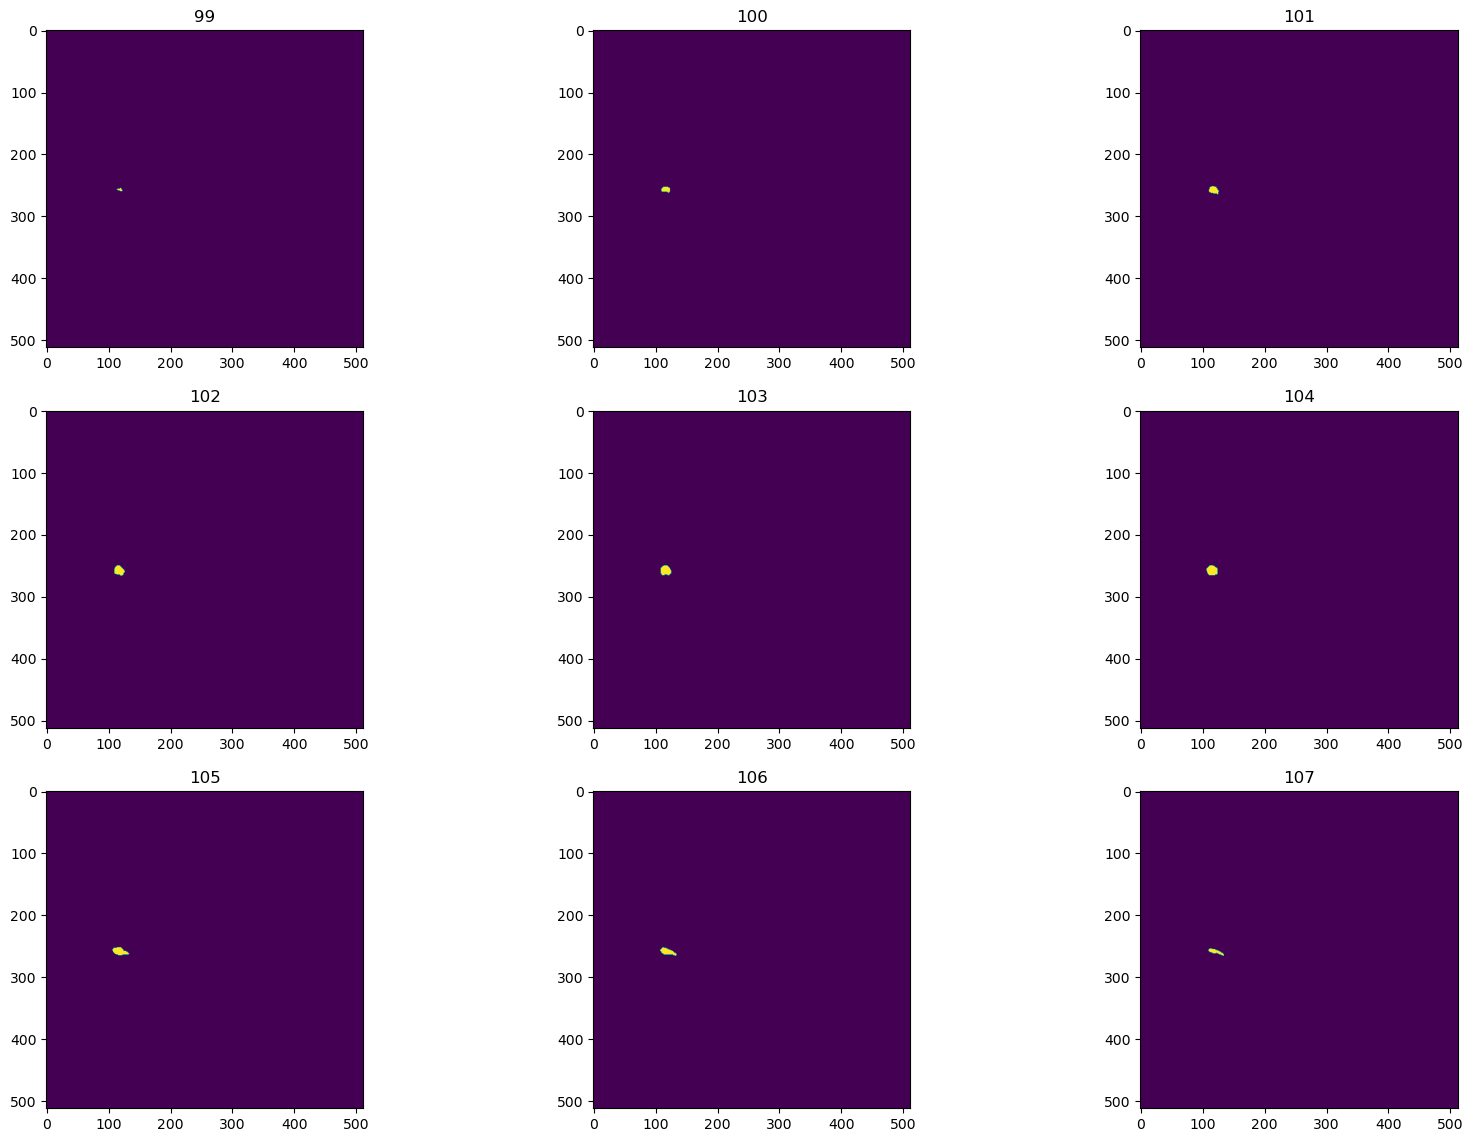

In [42]:
plot_ct(img_mask, index)

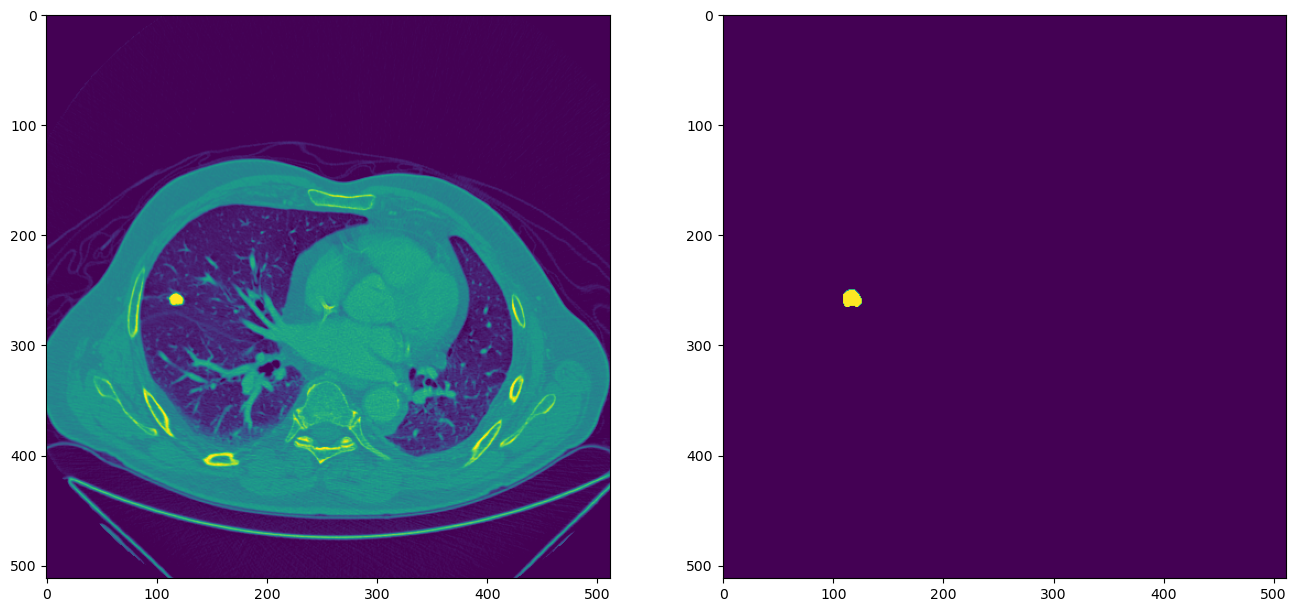

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(16,9))
axs[0].imshow(img_luna[103])
# axs[0].scatter(177, 413)
axs[1].imshow(img_mask[103])
# axs[1].scatter(177, 476)
plt.show()